<a href="https://colab.research.google.com/github/hamzaskhan/sketch-to-3D-reconstruction/blob/main/Custom_pipeline_PEDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom pipeline for converting grescale and sketches to 3D objects, by Hamza Khan.
My GAT model replaces Pix2Pix when it becomes improved. That is my subject of research. Until then, train the Pix2Pix on custom dataset focusing on the model you want.

## All of the code is written such that it runs on any google collab.
The pix2pix code below utilises pretrained edges2shoes dataset and thus its performance is not what you'd expect, so hang in there.

#### I am eternally grateful to the researchers who have developed the models below and all of the people who's efforts have brought me and all of us here. Thankyou, my unsung heroes.

### These are the steps for the pipeline, that turns Sketch-2-3D.

Step 1: Convert Edge2Image for converting sketch to image.


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix
Please upload a sketch image:


Saving chairr.jpg to chairr.jpg
Loading Pix2Pix model...
Model downloaded successfully.
initialize network with normal
loading the model from ./checkpoints/edges2shoes_pretrained/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
-----------------------------------------------
Pix2Pix model loaded successfully.
Converting sketch to 2D image...


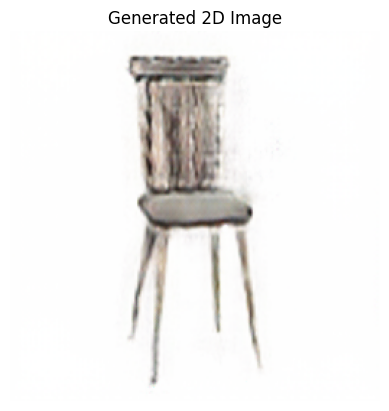

Conversion complete. Generated image saved at: generated_image.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## Step 1

# Install necessary libraries
!pip install torch torchvision matplotlib opencv-python pillow

# Clone the Pix2Pix repository (optional: for pretrained models)
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix/
!pip install -r requirements.txt

# Import necessary libraries
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from models.pix2pix_model import Pix2PixModel

# Load the Pix2Pix Model
def load_pix2pix_model():
    """
    Loads the pretrained Pix2Pix model for edge-to-photo translation.
    """
    model_path = "checkpoints/edges2shoes_pretrained/latest_net_G.pth"  # edges2shoes model checkpoint
    if not os.path.exists(model_path):
        print("Downloading pretrained Pix2Pix model weights...")
        os.system("bash ./scripts/download_pix2pix_model.sh edges2shoes")  # Use edges2photo model
        print("Model downloaded successfully.")

    # Set up options manually without relying on the command-line parser
    class CustomOptions:
        def __init__(self):
            self.dataroot = "./dummy_dataroot"
            self.isTrain = False  # Set model to evaluation mode
            self.model = 'pix2pix'
            self.name = 'edges2shoes_pretrained'
            self.checkpoints_dir = './checkpoints'
            self.dataset_mode = 'aligned'
            self.direction = 'AtoB'
            self.load_size = 256
            self.crop_size = 256
            self.input_nc = 3  # Number of input channels (3 for RGB images)
            self.output_nc = 3  # Number of output channels (3 for RGB images)
            self.ngf = 64
            self.ndf = 64
            self.netD = 'basic'
            self.netG = 'unet_256'
            self.n_layers_D = 3
            self.norm = 'batch'
            self.init_type = 'normal'
            self.init_gain = 0.02
            self.no_dropout = True
            self.serial_batches = False
            self.num_threads = 4
            self.batch_size = 1
            self.max_dataset_size = float("inf")
            self.preprocess = 'resize_and_crop'
            self.no_flip = True
            self.display_winsize = 256
            self.epoch = 'latest'
            self.load_iter = 0
            self.verbose = False
            self.suffix = ''
            self.use_wandb = False
            self.results_dir = './results/'
            self.aspect_ratio = 1.0
            self.phase = 'test'
            self.eval = True
            self.num_test = 50
            self.gpu_ids = [0]  # Set to an empty list [] for CPU-only execution

    # Create a dummy directory for dataroot
    os.makedirs("./dummy_dataroot", exist_ok=True)

    # Initialize the Pix2Pix model
    opt = CustomOptions()
    model = Pix2PixModel(opt)
    model.setup(opt)
    model.eval()  # Set the model to evaluation mode

    print("Pix2Pix model loaded successfully.")
    return model


# Function to process and convert sketch to 2D image
def convert_sketch_to_image(image_path, model):
    """
    Converts a sketch to a 2D realistic image using Pix2Pix.
    """
    # Load and preprocess the input sketch
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to model input size
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] as required by Pix2Pix
    ])
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Pass the sketch through the Pix2Pix model
    with torch.no_grad():
        output = model.netG(input_tensor.to(model.device))  # Generate the output

    # Convert the output tensor back to an image
    output_image = (output.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2  # Denormalize to [0, 1]
    output_image = (output_image * 255).astype("uint8")  # Convert to [0, 255]

    # Save the generated image
    generated_image_path = "generated_image.jpg"
    Image.fromarray(output_image).save(generated_image_path)

    # Display the generated image
    plt.imshow(output_image)
    plt.title("Generated 2D Image")
    plt.axis("off")
    plt.show()

    return generated_image_path


# Full sketch-to-image pipeline
def sketch_to_image_pipeline():
    """
    Handles the entire workflow:
    - Upload a sketch
    - Convert to 2D image using Pix2Pix
    """
    # Step 1: Upload Image
    print("Please upload a sketch image:")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Step 2: Get uploaded image path
    image_path = list(uploaded.keys())[0]

    # Step 3: Load Pix2Pix Model
    print("Loading Pix2Pix model...")
    pix2pix_model = load_pix2pix_model()

    # Step 4: Convert sketch to 2D image
    print("Converting sketch to 2D image...")
    generated_image_path = convert_sketch_to_image(image_path, pix2pix_model)

    print(f"Conversion complete. Generated image saved at: {generated_image_path}")
    return generated_image_path


# Run the pipeline
generated_image_path = sketch_to_image_pipeline()

# Download the generated image
if generated_image_path:
    print(f"Downloading the generated 2D image: {generated_image_path}")
    files.download(generated_image_path)


Step 2: Upscale Image resolution for finer edge details and detection.


Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 759 (delta 0), reused 2 (delta 0), pack-reused 755 (from 1)
Receiving objects: 100% (759/759), 5.39 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (406/406), done.
/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 22.1 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=165bf9635496ec0640546ad

Saving chair_sketch_ft_o1.jpg to chair_sketch_ft_o1.jpg
move chair_sketch_ft_o1.jpg to upload/chair_sketch_ft_o1.jpg
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 805.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

Name: torch
Version: 1.13.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: nvidia-cublas-cu11, nvidia-cuda-nvrtc-cu11, nvidia-cuda-runtime-cu11, nvidia-cudnn-cu11, typing-extensions
Required-by: accelerate, basicsr, facexlib, fastai, gfpgan, peft, realesrgan, sentence-transformers, timm, torchaudio, torchvision
---
Name: torchvision
Version: 0.14.1
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, requests, torch, typing-extensions
Required-by: basicsr, facexlib, fastai, gfpgan, realesrgan, timm
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

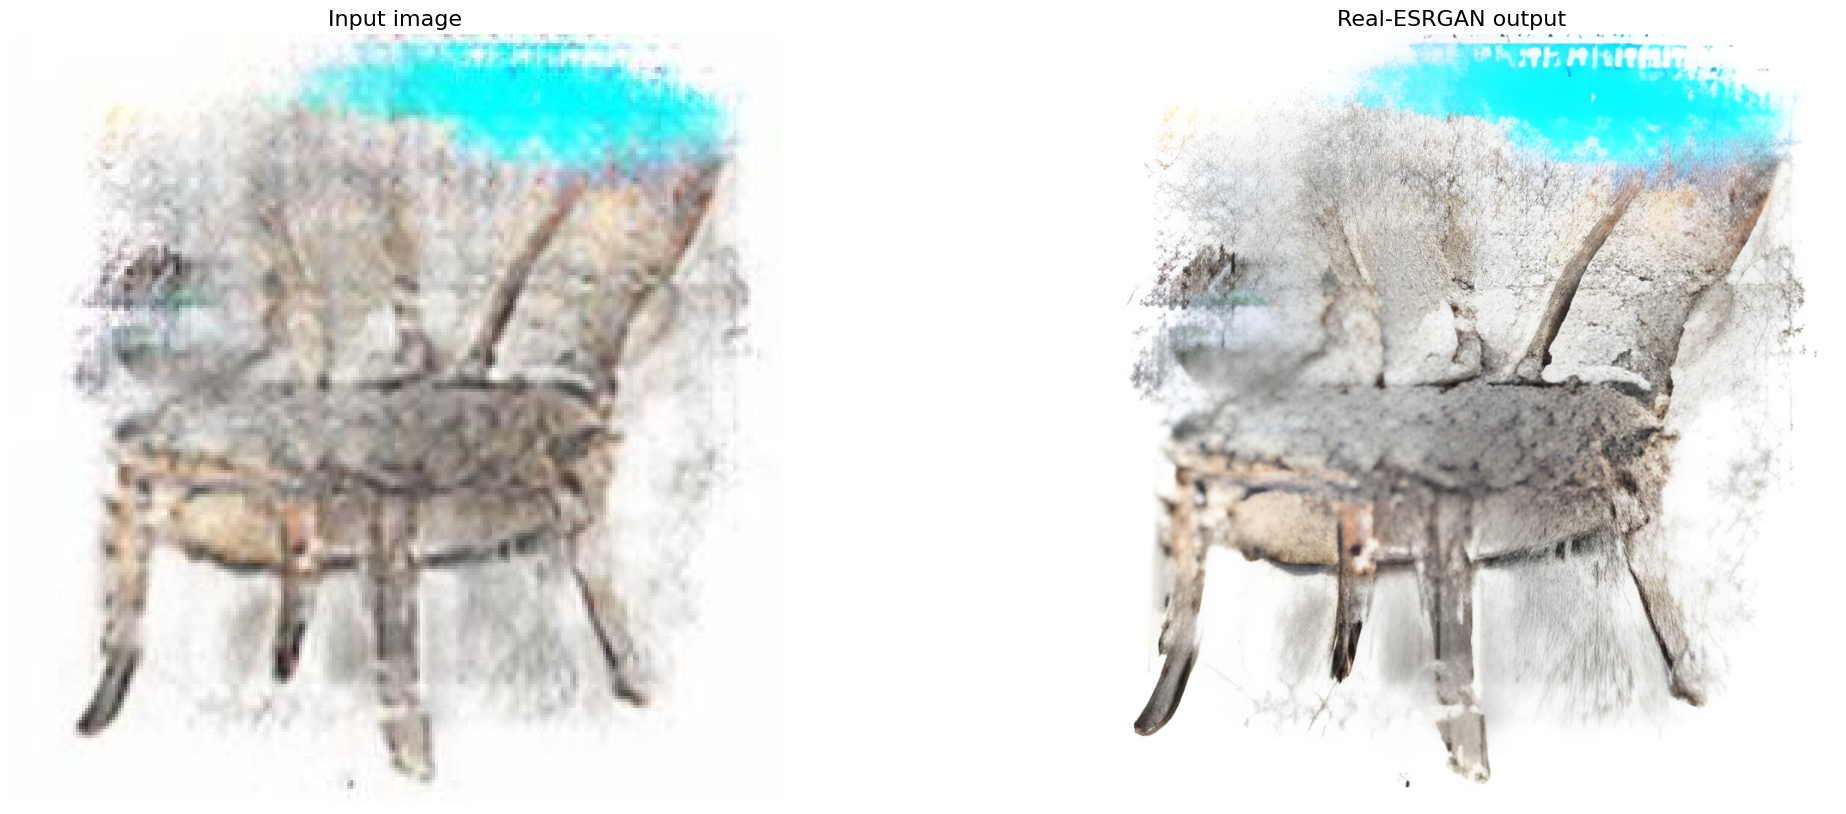

In [ ]:
## Step 2

###Step 2: unblur the image

# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)
  # if it is out of memory, try to use the `--tile` option
# We upsample the image with the scale factor X3.5
# !python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 --face_enhance
!pip uninstall -y torch torchvision
!pip install torch==1.13.1 torchvision==0.14.1
!pip install basicsr facexlib gfpgan
!pip show torch torchvision
!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 --face_enhance
# Arguments
# -n, --model_name: Model names
# -i, --input: input folder or image
# --outscale: Output scale, can be arbitrary scale factore.
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Real-ESRGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'upload'
result_folder = 'results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)
  # Download the results
zip_filename = 'Real-ESRGAN_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

Step 3: Add color to image for catching finer depth details.


Cloning into 'DeOldify'...
remote: Enumerating objects: 2620, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 2620 (delta 93), reused 212 (delta 73), pack-reused 2346 (from 1)
Receiving objects: 100% (2620/2620), 69.71 MiB | 26.44 MiB/s, done.
Resolving deltas: 100% (1176/1176), done.
/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/Real-ESRGAN/DeOldify
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 89.9 MB/s eta 0:00:00
  Created wheel for imgaug: filename=img

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


NumExpr defaulting to 2 threads.
GPU is available. Proceeding...
--2024-12-02 09:50:31--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 169.150.249.162, 2400:52e0:1a01::1114:1
Connecting to data.deepai.org (data.deepai.org)|169.150.249.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘./models/ColorizeArtistic_gen.pth’

./models/ColorizeAr 100%[===================>] 243.32M  4.84MB/s    in 50s     

2024-12-02 09:51:21 (4.89 MB/s) - ‘./models/ColorizeArtistic_gen.pth’ saved [255144681/255144681]



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  def _next_index(self):
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weigh

Saving chair_sketch_ft_o1_out.jpg to chair_sketch_ft_o1_out.jpg


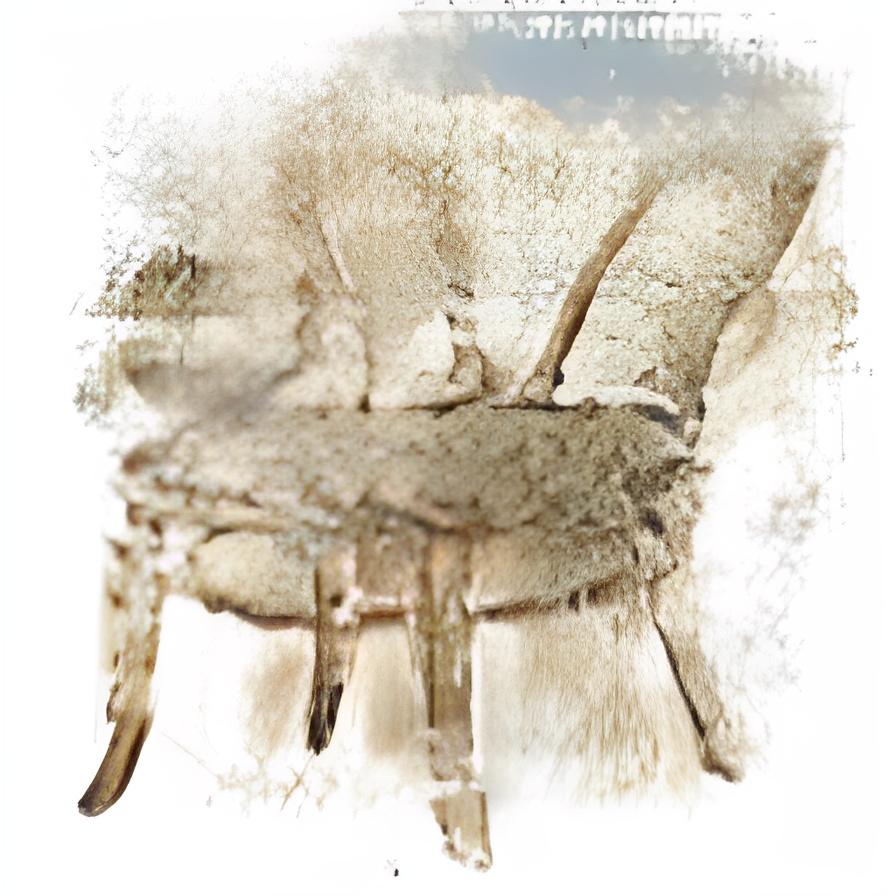

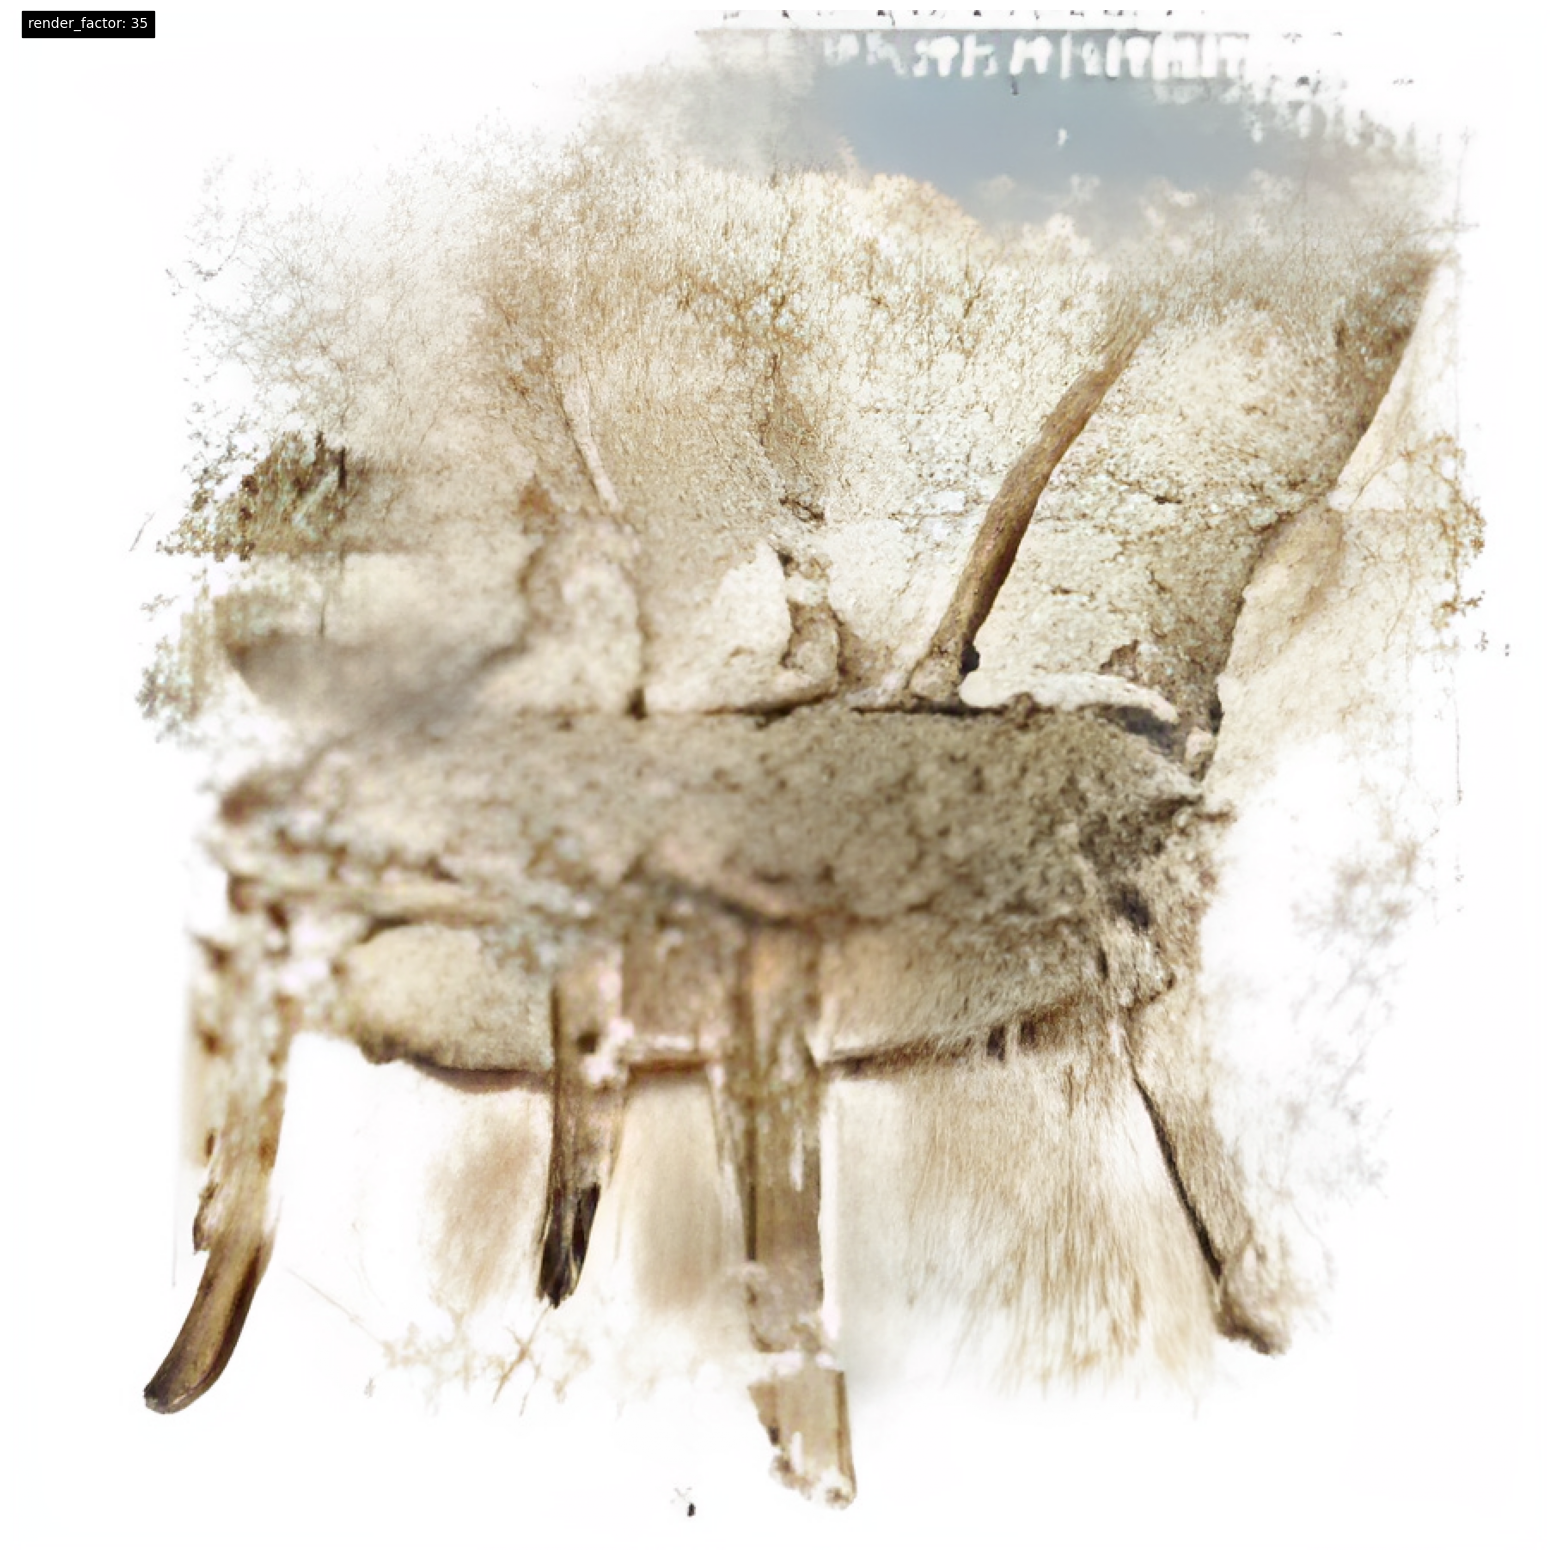

In [ ]:
## Step 3

# Clone the DeOldify repository
!git clone https://github.com/jantic/DeOldify.git DeOldify

# Change directory to DeOldify
%cd DeOldify

# Ensure the necessary device (GPU/CPU) is set up
from deoldify import device
from deoldify.device_id import DeviceId
device.set(device=DeviceId.GPU0)  # Choices: CPU, GPU0, GPU1, etc.

# Install dependencies
!pip install -r requirements-colab.txt

# Import libraries
import torch
import fastai
from deoldify.visualize import *
from google.colab import files
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

# Check if GPU is available
if not torch.cuda.is_available():
    print("GPU not available. Using CPU instead.")
else:
    print("GPU is available. Proceeding...")

# Create the 'models' directory and download the pretrained model
!mkdir -p 'models'
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth

# Initialize the colorizer
colorizer = get_image_colorizer(artistic=True)

# Upload an image
uploaded = files.upload()

if uploaded:
    # Get the uploaded file name
    uploaded_file_name = next(iter(uploaded.keys()))

    # Render factor and watermarked flag (can be adjusted)
    render_factor = 35  # Adjust render_factor for color intensity (higher = more vibrant)
    watermarked = True  # Set to False if you don't want the watermark

    # Colorize the uploaded image
    output_image_path = colorizer.plot_transformed_image(
        uploaded_file_name,
        render_factor=render_factor,
        display_render_factor=True,
        watermarked=watermarked
    )

    # Display the colorized image
    from IPython.display import display
    from PIL import Image
    colorized_image = Image.open(output_image_path)
    display(colorized_image)
else:
    print("No image uploaded. Please upload an image to proceed.")

# OPTIONAL: Render the same image with different render factors
# Uncomment the code below if you'd like to try rendering with varying factors
# for i in range(10, 40, 2):
#     colorizer.plot_transformed_image(uploaded_file_name, render_factor=i, display_render_factor=True, figsize=(8, 8))


Step 4: Generate Point Clouds and apply Sobel edges to increase accuracy of shape.
Step 5: Pre-process Point Clouds to decrease noise.
Step 6: Recreate .ply file.

In [ ]:
#Step 4, 5, and 6

# Clone and install SHAP-E and dependencies
!git clone https://github.com/openai/shap-e.git
%cd shap-e
!pip install -e .
import shap_e
print("shap-e installed successfully!")
!pip install rarfile opencv-python

import cv2  # For Sobel edge detection
import torch
import ipywidgets as widgets
from IPython.display import display
from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_mesh
from shap_e.util.image_util import load_image
from PIL import Image
import numpy as np
import os
import zipfile
from google.colab import files

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the required models
xm = load_model('transmitter', device=device)
model = load_model('image300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))

# Configurations
batch_size = 4
guidance_scale = 3.0

# Function to write a PLY file
def write_ply(mesh, filepath):
    verts = mesh.verts
    faces = mesh.faces

    with open(filepath, 'w') as ply_file:
        ply_file.write("ply\n")
        ply_file.write("format ascii 1.0\n")
        ply_file.write(f"element vertex {len(verts)}\n")
        ply_file.write("property float x\n")
        ply_file.write("property float y\n")
        ply_file.write("property float z\n")
        ply_file.write(f"element face {len(faces)}\n")
        ply_file.write("property list uchar int vertex_indices\n")
        ply_file.write("end_header\n")

        for vert in verts:
            ply_file.write(f"{vert[0]} {vert[1]} {vert[2]}\n")
        for face in faces:
            ply_file.write(f"3 {face[0]} {face[1]} {face[2]}\n")

# Preprocess function to apply Sobel edge detection
def preprocess_image(image_path):
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError("Could not load image")
    sobel_x = cv2.Sobel(original_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobel_x, sobel_y)
    sobel_edges = cv2.normalize(sobel_edges, None, 0, 255, cv2.NORM_MINMAX)
    sobel_edges = (sobel_edges * 2).clip(0, 255).astype(np.uint8)
    sobel_path = '/tmp/sobel_image.png'
    cv2.imwrite(sobel_path, sobel_edges)
    return sobel_path

# Define function to handle the upload process
def handle_upload(change):
    if uploader.value:
        uploaded_file = next(iter(uploader.value.values()))
        file_path = '/tmp/' + uploaded_file['metadata']['name']
        with open(file_path, 'wb') as f:
            f.write(uploaded_file['content'])
        sobel_path = preprocess_image(file_path)
        image = load_image(sobel_path)
        print(f"Sobel edges applied successfully: {sobel_path}")
        latents = sample_latents(
            batch_size=batch_size,
            model=model,
            diffusion=diffusion,
            guidance_scale=guidance_scale,
            model_kwargs=dict(images=[image] * batch_size),
            progress=True,
            clip_denoised=True,
            use_fp16=True,
            use_karras=True,
            karras_steps=128,
            sigma_min=1e-3,
            sigma_max=160,
            s_churn=0,
        )
        ply_paths = []
        for i, latent in enumerate(latents):
            mesh = decode_latent_mesh(xm, latent)
            ply_path = f"/tmp/point_cloud_{i}.ply"
            write_ply(mesh, ply_path)
            ply_paths.append(ply_path)
        zip_file_path = '/tmp/output_point_clouds.zip'
        with zipfile.ZipFile(zip_file_path, 'w') as zipf:
            for ply_path in ply_paths:
                zipf.write(ply_path, os.path.basename(ply_path))
        files.download(zip_file_path)

# Create a file upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

print("Please upload an image...")

uploader.observe(handle_upload, names='value')


Cloning into 'shap-e'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 336 (delta 41), reused 218 (delta 18), pack-reused 76 (from 1)
Receiving objects: 100% (336/336), 11.72 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/shap-e
Obtaining file:///content/shap-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-uja7ju_n/clip_d13adbeba71447a183fc7bbbde06bcd6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-uja7ju_n/clip_d13adbeba71447a183fc7bbbde06bcd6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/content/shap-e/shap_e/models/nn/checkpoint.py:32: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, run_function, length, *args):
/content/shap-e/shap_e/models/nn/checkpoint.py:44: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, *output_grads):
/content/shap-e/shap_e/models/nn/checkpoint.py:62: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, run_function, length_1, length_2, *args):
/content/shap-e/shap_e/models/nn/checkpoint.py:87: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, *all_output_grads):


  0%|          | 0.00/1.78G [00:00<?, ?iB/s]

/content/shap-e/shap_e/models/download.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)
100%|██████████████████████████████

  0%|          | 0.00/1.26G [00:00<?, ?iB/s]

/content/shap-e/shap_e/models/download.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


FileUpload(value={}, accept='image/*', description='Upload')

Please upload an image...
Sobel edges applied successfully: /tmp/sobel_image.png


  0%|          | 0/128 [00:00<?, ?it/s]

/content/shap-e/shap_e/models/stf/renderer.py:286: UserWarning: exception rendering with PyTorch3D: No module named 'pytorch3d'
  warnings.warn(f"exception rendering with PyTorch3D: {exc}")
/content/shap-e/shap_e/models/stf/renderer.py:287: UserWarning: falling back on native PyTorch renderer, which does not support full gradients
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install dependencies for mesh refinement and Chamfer Distance calculation
!pip install open3d  # For point cloud and mesh handling
!pip install pytorch3d  # For Chamfer Distance and 3D operations in PyTorch

import open3d as o3d  # Open3D library for 3D data manipulation
from pytorch3d.loss import chamfer_distance  # PyTorch3D for Chamfer Distance computation
import numpy as np  # For array operations
import torch  # PyTorch library
import zipfile  # For zipping generated files
import os  # To handle file paths
from google.colab import files  # To download files in Google Colab

# Function to compute Chamfer Distance between two point clouds
def compute_chamfer_distance(pcd1, pcd2):
    """
    Compute Chamfer Distance between two point clouds using PyTorch3D.
    """
    pcd1_tensor = torch.tensor(np.asarray(pcd1.points), dtype=torch.float32).unsqueeze(0).cuda()
    pcd2_tensor = torch.tensor(np.asarray(pcd2.points), dtype=torch.float32).unsqueeze(0).cuda()
    dist, _ = chamfer_distance(pcd1_tensor, pcd2_tensor)
    return dist.item()

# Function to perform Neural Mesh Refinement (NMR)
def refine_mesh(mesh):
    """
    Refine a mesh using a Neural Mesh Refinement (NMR) model.
    Currently, this is a placeholder function that returns the input mesh unchanged.
    Replace this with an NMR implementation or a pre-trained model.
    """
    # TODO: Implement a pre-trained NMR model (e.g., Mesh R-CNN or AtlasNet)
    return mesh

# Enhanced handler for generating, refining, and evaluating point clouds
def handle_upload_with_refinement(change):
    """
    Handle the upload of an image file, generate point clouds, refine meshes,
    compute Chamfer Distances, and save the results.
    """
    if uploader.value:
        # Extract the uploaded file
        uploaded_file = next(iter(uploader.value.values()))
        file_path = '/tmp/' + uploaded_file['metadata']['name']
        with open(file_path, 'wb') as f:
            f.write(uploaded_file['content'])

        # Preprocess the uploaded image to extract Sobel edges
        sobel_path = preprocess_image(file_path)
        image = load_image(sobel_path)
        print(f"Sobel edges applied successfully: {sobel_path}")

        # Generate latent vectors for point cloud generation
        latents = sample_latents(
            batch_size=batch_size,
            model=model,
            diffusion=diffusion,
            guidance_scale=guidance_scale,
            model_kwargs=dict(images=[image] * batch_size),
            progress=True,
            clip_denoised=True,
            use_fp16=True,
            use_karras=True,
            karras_steps=128,
            sigma_min=1e-3,
            sigma_max=160,
            s_churn=0,
        )

        # Initialize variables for storing results
        ply_paths = []
        chamfer_distances = []
        reference_pcd = None  # Reference point cloud for Chamfer Distance calculation

        # Process each latent vector to generate and refine point clouds
        for i, latent in enumerate(latents):
            # Decode the latent vector to a 3D mesh
            mesh = decode_latent_mesh(xm, latent)

            # Refine the mesh using Neural Mesh Refinement
            refined_mesh = refine_mesh(mesh)

            # Save the refined mesh as a .ply file
            ply_path = f"/tmp/refined_point_cloud_{i}.ply"
            write_ply(refined_mesh, ply_path)
            ply_paths.append(ply_path)

            # Convert the refined mesh to an Open3D point cloud
            refined_pcd = o3d.io.read_point_cloud(ply_path)

            # Set the first point cloud as the reference for Chamfer Distance
            if reference_pcd is None:
                reference_pcd = refined_pcd

            # Compute Chamfer Distance between the refined and reference point clouds
            cd = compute_chamfer_distance(refined_pcd, reference_pcd)
            chamfer_distances.append(cd)

        # Select the best point cloud based on the minimum Chamfer Distance
        best_idx = np.argmin(chamfer_distances)
        best_ply_path = ply_paths[best_idx]
        print(f"Best point cloud selected: {best_ply_path} (Chamfer Distance: {chamfer_distances[best_idx]:.6f})")

        # Load the best point cloud for further use or visualization
        best_pcd = o3d.io.read_point_cloud(best_ply_path)

        # Zip all the generated .ply files for download
        zip_file_path = '/tmp/output_point_clouds.zip'
        with zipfile.ZipFile(zip_file_path, 'w') as zipf:
            for ply_path in ply_paths:
                zipf.write(ply_path, os.path.basename(ply_path))
        files.download(zip_file_path)

# Attach the enhanced handler to the upload widget
uploader.observe(handle_upload_with_refinement, names='value')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.

ModuleNotFoundError: No module named 'pytorch3d'